本章では，Bo Pang氏とLillian Lee氏が公開しているMovie Review Dataのsentence polarity dataset v1.0を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

## 70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）

rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）

上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [7]:
with open("data/sentiment.txt", "a") as a:
    for pos in  open("data/rt-polaritydata/rt-polaritydata/rt-polarity.pos", encoding='iso8859_2'):
        a.write('+1' + pos)
    for neg in  open("data/rt-polaritydata/rt-polaritydata/rt-polarity.neg", encoding='iso8859_2'):
        a.write('-1' + neg)
    

In [8]:
!sort -R data/sentiment.txt -o data/sentiment.txt

In [9]:
pos = 0
neg = 0
for line in open('data/sentiment.txt'):
    if line[:2] == '+1':
        pos += 1
    else:
        neg += 1
print(f'posの数は{pos},negの数は{neg}')

posの数は10662,negの数は10662


## 71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [10]:
# 順番はどうでも良いので集合にする
stop_words=set(["(", ")", "--", ",", ".", ";", ":", "\'", "\"", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

In [11]:
def stop_words_have(word):
    return word in stop_words

In [12]:
for i in stop_words:
    if stop_words_have(i) == False:
        break

## 72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [13]:
from collections import Counter
from stemming.porter2 import stem

In [14]:
with open('data/file72.txt', 'w')as a:
    for line in open('data/sentiment.txt'):
        a.write(' '.join([stem(word) for word in line[2:].split() if not stop_words_have(stem(word))]) + '\n')

In [15]:
words = []
for line in open('data/file72'):
    words += line.split()
count=Counter(words)
print(len(words))

230084


In [22]:
with open('data/features.txt', 'w')as w:
    w.write('\n'.join([i for i in count if count[i] >= 10 and count[i] < 1000 ]))

## 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [4]:
import numpy as np

In [5]:
answer = []
for line in open('data/sentiment.txt'):
    answer.append(int(line[:2])/2+0.5)
answer = np.array(answer)

In [6]:
import numpy as np
import scipy as sp

with open('data/features')as r:
    features = r.read().split()
print(len(features))

3752


In [7]:
num_of_line = sum(1 for i in open('data/file72.txt', 'r'))
num_of_features = sum(1 for i in open('data/features.txt', 'r'))

# matrix[i, j]: i番目の文章にj番目の特徴単語が見つかるか？
matrix = np.zeros((num_of_line, num_of_features + 1))
matrix[:,0] = 1
for i, line in enumerate(open('data/file72.txt')):
    for word in  line.split():
        if word in features:
            matrix[i][features.index(word) + 1] = 1

In [8]:
answer

array([ 1.,  1.,  0., ...,  1.,  0.,  0.])

In [43]:
v = np.random.rand(num_of_features + 1)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# 学習するのはここの部分です。
N = 500
learn_rate = 0.001
for i in range(N):
    v += learn_rate * np.dot(answer - sigmoid(np.dot(matrix,v)), matrix)

In [12]:
v

array([ -8.66712104e+02,  -1.69467979e+01,  -6.54415748e+00, ...,
         2.04343760e-01,  -2.17913842e-01,   2.54261976e-01])

In [62]:
A = np.dot(matrix, v)

In [65]:
print(matrix.shape, v.shape, A.shape)

(21324, 3753) (3753,) (21324,)


## 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

In [67]:
def predict(sentence):
    sentence_vector = np.zeros(num_of_features + 1)
    for word in sentence.split():
        if word in features:
            sentence_vector[fetures.index(word) + 1] = 1
    result = sigmoids(np.dot(sentence_vector,v))
    if result > 0.5:
        return "+1", result
    else:
        return "-1", 1 - result

## 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [44]:
lst75 = np.argsort(v)[::-1]

In [45]:
for i in range(10):
    print(features[lst75[i] - 1])

engross
refresh
unexpect
glorious
remark
resist
examin
mesmer
sli
witti


In [46]:
for i in range(10):
    print(features[lst75[-i] - 1])

engross
bore
wast
neither
dull
fail
flat
suppos
mediocr
generic


## 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [70]:
with open('data/file76.txt', 'w')as a:
    for i, j in zip(answer, sigmoid(np.dot(matrix,v))):
        if j > 0.5:
            a.write(str(int(i)) + '\t' + str(1) + '\t' + str(j)+ '\n')
        else:
            a.write(str(int(i)) + '\t' + str(0) + '\t' + str(1 - j) + '\n')

## 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ

In [75]:
def prediction_rate_from(file_name):
    correct = 0
    counter = 0
    for line in open('data/file76.txt'):
        counter += 1
        x = line.split()
        if x[0] == x[1]:
            correct += 1
    print("予測の正解率は", correct / counter)
    return correct / counter
    

In [76]:
def fit_rate_from(file_name):
    correct = 0
    counter = 0
    for line in open(file_name):
        x = line.split()
        if x[0] == '1' and x[1] == '1':
            correct += 1
        if x[1] == '1':
            counter += 1
    print("正例に関する適合率", correct / counter)
    return correct / counter

In [77]:
def recall_rate_from(file_name):
    correct = 0
    counter = 0
    for line in open(file_name):
        x = line.split()
        if x[0] == '1' and x[1] == '1':
            correct += 1
        if x[0] == '1':
            counter += 1
    print("再現率は", correct / counter)

In [78]:
prediction_rate_from('data/file76.txt')
fit_rate_from('data/file76.txt')
recall_rate_from('data/file76.txt')

予測の正解率は 0.814856499718627
正例に関する適合率 0.7411984480528812
再現率は 0.9675483023822923


## 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [27]:
one_fifth_matrix = matrix[:int(num_of_line / 5)]
four_fifth_matrix = matrix[int(num_of_line / 5):]
one_fifth_answer = answer[:int(num_of_line / 5)]
four_fifth_answer = answer[int(num_of_line / 5):]

In [51]:
print(matrix.shape,  four_fifth_matrix.shape)

(21324, 3753) (17060, 3753)


In [52]:
v2 = np.random.rand(num_of_features + 1)

N = 500
learn_rate = 0.001
for i in range(N):
    v2 += learn_rate * np.dot(four_fifth_answer - sigmoid(np.dot(four_fifth_matrix,v2)), four_fifth_matrix)

In [61]:
with open('data/file78.txt', 'w')as a:
    for i, j in zip(one_fifth_answer, sigmoid(np.dot(one_fifth_matrix,v2))):
        if j > 0.5:
            a.write(str(int(i)) + '\t' + str(1) + '\t' + str(j)+ '\n')
        else:
            a.write(str(int(i)) + '\t' + str(0) + '\t' + str(1 - j) + '\n')

In [68]:
prediction_rate_from('data/file78.txt')
fit_rate_from('data/file78.txt')
recall_rate_from('data/file78.txt')

予測の正解率は 0.7749015194147439
正例に関する適合率 0.6988352745424293
再現率は 0.8030592734225621


## 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

In [74]:
with open('data/file79.txt', 'w')as a:
    for i, j in zip(one_fifth_answer, sigmoid(np.dot(one_fifth_matrix,v2))):
        a.write(str(int(i)) + '\t' + str(1) + '\t' + str(j)+ '\n')

In [88]:
def fit_rate_from_list(lst):
    correct = 0
    counter = 0
    for line in lst:
        if x[0] == '1' and x[1] == '1':
            correct += 1
        if x[1] == '1':
            counter += 1
    return correct / counter

def recall_rate_from_list(lst):
    correct = 0
    counter = 0
    for line in lst:
        if x[0] == '1' and x[1] == '1':
            correct += 1
        if x[0] == '1':
            counter += 1
    return correct / counter

def adaption_recall_graph(threshold):
    adaption_recall = []
    
    for line in open('data/file79.txt'):
        data = line.split()
        i, j = int(data[0]), float(data[2])
        if j > threshold:
            adaption_recall.append([i, 1])
        else:
            adaption_recall.append([i, 0])
    return fit_rate_from_list(adaption_recall), recall_rate_from_list(adaption_recall)

f = np.frompyfunc(adaption_recall_graph, 1, 2)

X = np.linspace(0, 1, 100, endpoint = False)
p, r = f(X)
plt.plot(X, p, label = 'precision rate')
plt.plot(X, r, label = 'recall rate')
plt.legend()
plt.show()

ZeroDivisionError: division by zero

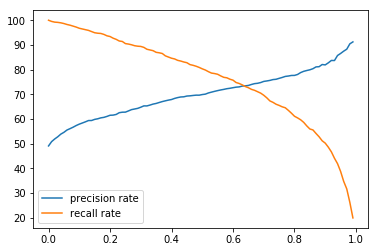

In [90]:
import matplotlib.pyplot as plt

def precision_rate(lst79):
    lst=[]
    for x in lst79:
        if x[0] == 1 and x[1] == 1:
            lst.append(True)
        elif x[1] == 1:
            lst.append(False)
    return len([i for i in lst if i == True])/len(lst)*100

def recall_rate(lst79):
    lst=[]
    for x in lst79:
        if x[0] == 1 and x[1] == 1:
            lst.append(True)
        elif x[0] == 1:
            lst.append(False)
    return len([i for i in lst if i == True])/len(lst)*100

def f79(x):
    lst79 = []
    for line in open('data/file79.txt'):
        data = line.split()
        i, j = int(data[0]), float(data[2])
        if j > x:
            lst79.append([i, 1])
        else:
            lst79.append([i, 0])
    #print(lst79)
    return precision_rate(lst79), recall_rate(lst79)

f = np.frompyfunc(f79, 1, 2)

X = np.linspace(0, 1, 100, endpoint = False)
p, r = f(X)
plt.plot(X, p, label = 'precision rate')
plt.plot(X, r, label = 'recall rate')
plt.legend()
plt.show()